# 한국 지수
심볼	설명

KS11 : KOSPI 지수

KQ11 : KOSDAQ 지수

KS50 : KOSPI 50 지수

KS100 : KOSPI 100

KRX100 : KRX 100

KS200 : 코스피 200

# 미국 지수
심볼	설명

DJI	: 다우존스 지수

IXIC : 나스닥 지수

US500 : S&P 500 지수

VIX : S&P 500 VIX

_______________________________________________________________________________________________________________________________________

# 시차

그래프의 날짜는 모두 미국 시간

미국 장은 우리 시간으로 밤 11시 30분(서머타임 적용시 10시 30분) ~ 다음날 새벽 6시(서머타임 적용시 새벽 5시)

우리 시간으로 오후 2시 ~ 오전 12시 (서머타임 적용시 오후 1시 ~ 오전 12시) 에 실행하면 다음날 새벽 6시(서머타임 적용시 새벽 5시)에 나올 종가를 알려줌

우리 시간으로 새벽 6시 ~ 오후 2시 (서머타임 적용시 새벽 5시 ~ 오후 1시) 에 실행하면 다음날 새벽 6시 (서머타임 적용시 새벽 5시) 에 나올 종가를 알려줌

우리 시간으로 오전 12시 ~ 새벽 6시(서머타임 적용시 오전 12시 ~ 새벽 5시) 에 실행하면 미국 장이 마감되지 않았으므로 예측이 정확하지 않을 것임

예시 : 우리 시간 9월 15일 (서머타임 적용) 오후 2시에 실행 : 미국 날짜로 9월 15일의 종가를 예측
예시 : 우리 시간 9월 15일 (서머타임 적용) 오전 10시에 실행 : 미국 날짜로 9월 15일의 종가를 예측

_______________________________________________________________________________________________________________________________________

#### 나스닥, 다우, s&p500, 코스피, 코스닥 각각 2000-01-01일 부터 2020-06-05일 까지 데이터 사용해 모델 구성

#### 필요한 패키지 : keras, pandas, numpy, FinanceDataReader, bokeh, datetime, sklearn, tensorflow


# 출력물 예시

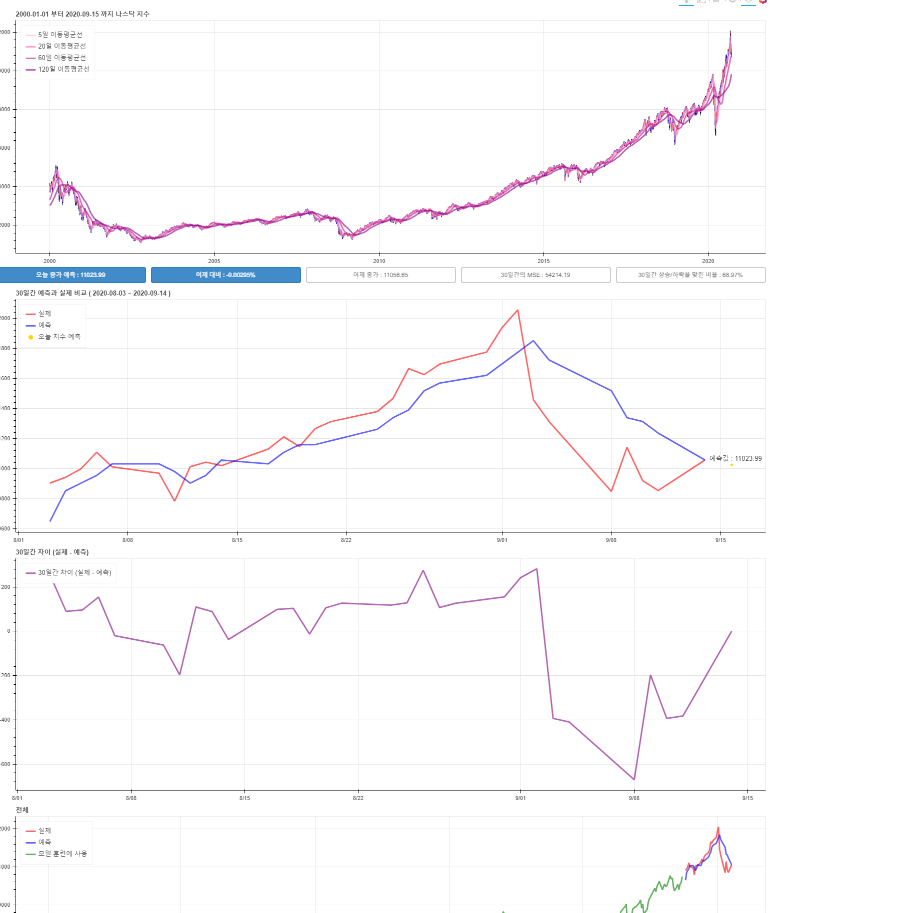

# 시각화 코드

In [2]:
종목명 = '나스닥'
티커 = 'IXIC' # 다른 지수를 보려면 위에 있는 심볼을 참고하여 변경
start = '2000-01-01'
모델json파일 = "C:/Users/kim98/jupyter/project/dashboard_final/NASDAQ.json"
모델h5파일 = "C:/Users/kim98/jupyter/project/dashboard_final/NASDAQ.h5"

from keras.models import model_from_json

import pandas as pd
import numpy as np

import FinanceDataReader as fdr

from datetime import datetime, timedelta, date

from bokeh.io import output_notebook,show, output_file
from bokeh.resources import INLINE

from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, CustomJS, DateRangeSlider, Button, HoverTool

from bokeh.layouts import layout, row, column, gridplot
from sklearn.metrics import mean_squared_error

from bokeh.plotting import figure, curdoc, show, output_file

import time


json_file = open(모델json파일, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights(모델h5파일)
print("Loaded model from disk")

loaded_model.compile(optimizer='adam', loss='mean_squared_error')

TEST_SIZE = 60

yesterday =  datetime.today() - timedelta(1)
yesterday.strftime("%Y-%m-%d")

test = fdr.DataReader(티커, yesterday - timedelta(100), yesterday)
test = test.drop(['Change', 'Volume'], axis = 1)

max_test_close = max(test['Close'])
min_test_close = min(test['Close'])
max_test_open = max(test['Open'])
min_test_open = min(test['Open'])
max_test_high = max(test['High'])
min_test_high = min(test['High'])
max_test_low = max(test['Low'])
min_test_low = min(test['Low'])

cols = test.columns.tolist()
cols = cols[-3:] + cols[:-3]
test = test[cols]

test = test[-TEST_SIZE:]

test_scaled = test.copy()
test_scaled['Open'] = np.array((test_scaled['Open']-min_test_open)/(max_test_open-min_test_open))
test_scaled['High'] = np.array((test_scaled['High']-min_test_high)/(max_test_high-min_test_high))
test_scaled['Low'] = np.array((test_scaled['Low']-min_test_low)/(max_test_low-min_test_low))
test_scaled['Close'] = np.array((test_scaled['Close']-min_test_close)/(max_test_close-min_test_close))

test_scaled = test_scaled.values

y_pred = []
y_test = []

for i in range(30, test.shape[0]):
    x_test = []

    x_test.append(test_scaled[i-30:i]) # 30일 기준으로 데이터 나눠서 학습
    y_test.append(test_scaled[i, 3]) # 3번째 열 close(종가) 예측
    x_test = np.array(x_test)

    res = round(loaded_model.predict(x_test).item(),2)
    y_pred.append(res)

y_pred = np.array(y_pred)
y_test = np.array(y_test)

y_test = (max_test_close-min_test_close) * y_test + min_test_close
y_pred = (max_test_close-min_test_close) * y_pred + min_test_close

comparison = pd.DataFrame(y_pred, y_test)
comparison.reset_index(level=0, inplace=True)
comparison.index = np.array(test[-TEST_SIZE+30:].index)

comparison.columns = ['test', 'pred']

start_date = datetime.strptime(start, '%Y-%m-%d')

df = fdr.DataReader(티커, (start_date-timedelta(180)).strftime('%Y-%m-%d'), datetime.today().strftime('%Y-%m-%d'))
df = df.drop(['Change', 'Volume'], axis = 1)

df['date'] = pd.to_datetime(df.index)
df["DateString"] = df["date"].dt.strftime("%Y-%m-%d")

# 이동평균선

ma5 = df['Close'].rolling(window=5).mean()
ma20 = df['Close'].rolling(window=20).mean()
ma60 = df['Close'].rolling(window=60).mean()
ma120 = df['Close'].rolling(window=120).mean()

df.insert(len(df.columns), "MA5", ma5)
df.insert(len(df.columns), "MA20", ma20)
df.insert(len(df.columns), "MA60", ma60)
df.insert(len(df.columns), "MA120", ma120)

for i in range(5-1):
    df['MA5'][i] = df.Close[i]
for i in range(20-1):
    df['MA20'][i] = df.Close[i]
for i in range(60-1):
    df['MA60'][i] = df.Close[i]
for i in range(120-1):
    df['MA120'][i] = df.Close[i]

df = df[df.index >= start_date]

inc = df.Close >= df.Open
dec = df.Open > df.Close

#####################################################################

yesterday =  datetime.today() - timedelta(1)

test = fdr.DataReader(티커, (datetime.today() - timedelta(45)).strftime("%Y-%m-%d"), yesterday.strftime("%Y-%m-%d")) # 어제까지 30일의 test
test = test.drop(['Change', 'Volume'], axis = 1)

TEST_SIZE = 31

max_test_close = max(test['Close'])
min_test_close = min(test['Close'])
max_test_open = max(test['Open'])
min_test_open = min(test['Open'])
max_test_high = max(test['High'])
min_test_high = min(test['High'])
max_test_low = max(test['Low'])
min_test_low = min(test['Low'])

cols = test.columns.tolist()
cols = cols[-3:] + cols[:-3]
test = test[cols]

test = test[-TEST_SIZE:]

test_scaled = test.copy()
test_scaled['Open'] = np.array((test_scaled['Open']-min_test_open)/(max_test_open-min_test_open))
test_scaled['High'] = np.array((test_scaled['High']-min_test_high)/(max_test_high-min_test_high))
test_scaled['Low'] = np.array((test_scaled['Low']-min_test_low)/(max_test_low-min_test_low))
test_scaled['Close'] = np.array((test_scaled['Close']-min_test_close)/(max_test_close-min_test_close))

test_scaled = test_scaled.values

x_test = []

x_test.append(test_scaled)
x_test = np.array(x_test)

pred = loaded_model.predict(x_test).item()

pred = (max_test_close-min_test_close) * pred + min_test_close

pred = round(pred, 2)

######################################################################

w = 12*70*70*1000

sourceInc=ColumnDataSource(ColumnDataSource.from_df(df.loc[inc]))
sourceDec=ColumnDataSource(ColumnDataSource.from_df(df.loc[dec]))
sourceall = ColumnDataSource(ColumnDataSource.from_df(df))

hover = HoverTool(
    tooltips=[
        ("날짜", "@DateString"),
        ("시가", "@Open"),
        ("종가", "@Close")
    ]
)

Tools = [hover,"pan,wheel_zoom,box_zoom,reset"]

p1 = figure(tools = Tools, x_axis_type="datetime", plot_width=1500, plot_height=500, title = start+" 부터 "+datetime.today().strftime('%Y-%m-%d')+ " 까지 나스닥 지수")

p1.segment('date', 'High', 'date', 'Low', color="black", source = sourceall)

p1.vbar('date', w, 'Open', 'Close', fill_color="red", line_color="red", source = sourceInc)

p1.vbar('date', w, 'Open', 'Close', fill_color="blue", line_color="blue", source = sourceDec)

p1.line(x= df.index, y=df.MA5, line_color="pink", line_width=3, line_alpha=0.6, legend_label='5일 이동평균선', muted_color = 'gray', muted_alpha = 0.3)
p1.line(x= df.index, y=df.MA20, line_color="hotpink", line_width=3, line_alpha=0.6, legend_label='20일 이동평균선', muted_color = 'gray', muted_alpha = 0.3)
p1.line(x= df.index, y=df.MA60, line_color="mediumvioletred", line_width=3, line_alpha=0.6, legend_label='60일 이동평균선', muted_color = 'gray', muted_alpha = 0.3)
p1.line(x= df.index, y=df.MA120, line_color="darkmagenta", line_width=3, line_alpha=0.6, legend_label='120일 이동평균선', muted_color = 'gray', muted_alpha = 0.3)

p1.legend.location = "top_left"
p1.legend.click_policy="mute"

comparison['date'] = pd.to_datetime(comparison.index)
comparison["DateString"] = comparison["date"].dt.strftime("%Y-%m-%d")

source = ColumnDataSource(ColumnDataSource.from_df(comparison))

hover = HoverTool(
    tooltips=[
        ("날짜", "@DateString"),
        ("예측", "@pred"),
        ("실제", "@test")
    ]
)
Tools = [hover,"pan,wheel_zoom,box_zoom,reset"]

p2 = figure(tools = Tools, x_axis_type="datetime", plot_width=1500, plot_height=500, title = "30일간 예측과 실제 비교 ( "+str(comparison.index[0])[:10]+ " ~ " + str(comparison.index[29])[:10] + " )")

p2.line(source = source, x= 'date', y='test', line_color="red", line_width=3, line_alpha=0.6, legend_label='실제', muted_color = 'gray', muted_alpha = 0.3)
p2.line(source = source, x= 'date', y='pred', line_color="blue", line_width=3, line_alpha=0.6, legend_label='예측', muted_color = 'gray', muted_alpha = 0.3)

p2.circle(datetime.today(), pred, size = 4, color = 'gold', legend_label = '오늘 지수 예측', muted_color = 'gray')

pred_label = []
pred_label.append("예측값 : ")
pred_label.append(str(round(pred, 2)))
pred_label = ''.join(pred_label)

source = ColumnDataSource(data = dict(name = [pred_label]))

labels = LabelSet(x = datetime.today(), y = pred, text = "name", x_offset = -45, y_offset = 5, render_mode = 'canvas', source = source, text_font_size = '10pt')
p2.add_layout(labels)

p2.legend.location = "top_left"
p2.legend.click_policy="mute"

comparison['diff'] = comparison['test']-comparison['pred']

source = ColumnDataSource(ColumnDataSource.from_df(comparison))

hover = HoverTool(
    tooltips=[
        ("날짜", "@DateString"),
        ("차이", "@diff")
    ]
)
Tools = [hover,"pan,wheel_zoom,box_zoom,reset"]

p3 = figure(tools = Tools, x_axis_type="datetime", plot_width=1500, plot_height=500, title = "30일간 차이 (실제 - 예측)")

p3.line(source = source, x= 'date', y='diff', line_color="purple", line_width=3, line_alpha=0.6, legend_label='30일간 차이 (실제 - 예측)')

p3.legend.location = "top_left"

yesterday =  datetime.today() - timedelta(1)

df2 = fdr.DataReader(티커, '2019-01-01', yesterday.strftime("%Y-%m-%d")) # 2000년부터 2020-05-31일까지 데이터 학습
train_value = df2[:-60+30]

comparison_test_list = [float(i) for i in comparison.test]
comparison_pred_list = [float(i) for i in comparison.pred]
train_value_Close_list = [float(i) for i in train_value.Close]

######
source_comparison = ColumnDataSource(data = dict(date = comparison.index, test = comparison_test_list, pred = comparison_pred_list))
source_train = ColumnDataSource(data = dict(date = train_value.index, Close = train_value_Close_list))

#hover = HoverTool(tooltips = [("Close", "@test"), ("pred", "@pred"), ("Close", "@Close"), ("date", "@date")])
Tools = ["pan,wheel_zoom,box_zoom,reset"]
######

p4 = figure(x_axis_type="datetime", plot_width=1500, plot_height=500, title = "전체", tools = Tools)

p4.line(x = 'date', y = 'test', line_color="red", line_width=3, line_alpha=0.6, legend_label='실제', muted_color = 'gray', muted_alpha = 0.3, source = source_comparison)
p4.line(x = 'date', y = 'pred', line_color="blue", line_width=3, line_alpha=0.6, legend_label='예측', muted_color = 'gray', muted_alpha = 0.3, source = source_comparison)
p4.line(x = 'date', y = 'Close', line_color="green", line_width=3, line_alpha=0.6, legend_label='모델 훈련에 사용', muted_color = 'gray', muted_alpha = 0.3, source = source_train)

p4.legend.location = "top_left"
p4.legend.click_policy="mute"


prob_list = []
y_test_res = []
y_pred_res = []

y_pred = comparison['pred']
y_test = comparison['test']

for i in range(len(y_pred)-1):
    if (y_test[i+1]-y_test[i])*(y_pred[i+1]-y_pred[i]) >= 0:
        prob_list.append(1)
    else:
        prob_list.append(0)
    if (y_test[i+1]-y_test[i]) >= 0 :
        y_test_res.append('up')
    else :
        y_test_res.append('down')
    if (y_pred[i+1]-y_pred[i]) >= 0 :
        y_pred_res.append('up')
    else :
        y_pred_res.append('down')

labels = ['down','up']

#    return(classification_report(y_test_res, y_pred_res))

new1 = []
new1.append('오늘 종가 예측 : ')
new1.append(str(pred))
a = ''.join(new1)

new2 = []
new2.append('어제 대비 : ')
new2.append(str(round((pred-test.Close[29])/test.Close[29],5)))
new2.append("%")
b = ''.join(new2)

if (pred-test.Close[29])/test.Close[29] >= 0:
    p5 = Button(label = a, button_type = "danger")
    p6 = Button(label = b, button_type = "danger")
else :
    p5 = Button(label = a, button_type = "primary")
    p6 = Button(label = b, button_type = "primary")

new5 = []
new5.append('어제 종가 : ')
new5.append(str(round(test.Close[29],2)))
e = ''.join(new5)

p9 = Button(label = e)

new3 = []
new3.append("30일간의 MSE : ")
new3.append(str(round(mean_squared_error(y_test, y_pred),2)))
c = ''.join(new3)

p7 = Button(label = c)

new4 = []
new4.append("30일간 상승/하락을 맞힌 비율 : ")
new4.append(str(round(100 * sum(prob_list)/len(prob_list), 2)))
new4.append("%")
d = ''.join(new4)

p8 = Button(label = d)

button_row = row(p5, p6, p9, p7, p8)#, sizing_mode = "scale_width")

# 여기서부터 그래프

#bokeh_doc = curdoc()

col1 = column(p1, button_row, p2, p3, p4, sizing_mode = "scale_width")#

l = gridplot([[col1]]) #

show(l)

#curdoc().add_root(l)

#bokeh_doc.title = 'test'

loaded_model.summary()

Loaded model from disk


<ipython-input-2-a29208fb91f4>:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA5'][i] = df.Close[i]
<ipython-input-2-a29208fb91f4>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA20'][i] = df.Close[i]
<ipython-input-2-a29208fb91f4>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA60'][i] = df.Close[i]
<ipython-input-2-a29208fb91f4>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           42000     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 150)           150600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1

# 모델링 코드

In [ ]:
import pandas as pd
import numpy as np

import FinanceDataReader as fdr

from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import swish

from datetime import datetime, timedelta

from keras.models import load_model
from google.colab import files

티커 = 'KQ11'

df = fdr.DataReader(티커, '2000-01-01', '2020-06-05') # 2000년부터 2020-05-31일까지 데이터 학습
df = df.drop(['Change', 'Volume'], axis = 1)

cols = df.columns.tolist()
cols = cols[-3:] + cols[:-3]

df = df[cols]

df_scaled = df.copy()
df_scaled['Open'] = np.array((df_scaled['Open']-min(df_scaled['Open']))/(max(df_scaled['Open'])-min(df_scaled['Open'])))
df_scaled['High'] = np.array((df_scaled['High']-min(df_scaled['High']))/(max(df_scaled['High'])-min(df_scaled['High'])))
df_scaled['Low'] = np.array((df_scaled['Low']-min(df_scaled['Low']))/(max(df_scaled['Low'])-min(df_scaled['Low'])))
df_scaled['Close'] = np.array((df_scaled['Close']-min(df_scaled['Close']))/(max(df_scaled['Close'])-min(df_scaled['Close'])))

# def scaled(column) : 
# return(np.array((column-min(column))/(max(column)-min(column)))) 이렇게 함수 짜서 쓸수도

df_scaled = df_scaled.values
train = df_scaled

x_train = []
y_train = []

for i in range(30, train.shape[0]):
x_train.append(train[i-30:i]) # 30일 기준으로 데이터 나눠서 학습
y_train.append(train[i, 3]) # 3번째 열 close(종가) 예측

x_train, y_train = np.array(x_train), np.array(y_train)

regression = Sequential()
regression.add(LSTM(units=100, activation="swish", return_sequences=True, input_shape = (x_train.shape[1], 4)))
regression.add(Dropout(0.2))

regression.add(LSTM(units=150, activation="swish", return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=300, activation="swish", return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=400, activation="swish"))
regression.add(Dropout(0.2))

regression.add(Dense(units = 1))

regression.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
mc = ModelCheckpoint('best_model', monitor='loss', mode='min', save_best_only=True)

tf.keras.utils.plot_model(regression, 'multi_input_and_output_model.png', show_shapes=True)
regression.fit(x_train, y_train, epochs=250, batch_size=32, callbacks = [es, mc])